<a href="https://colab.research.google.com/github/imranajec/-Machine_Learning_PyTorch_Exercise/blob/main/Spatial_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [ ]:
#importing the necessary frameworks

import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# I am mounting the to the drive as all the necessary downloads, data and model weights should be saved.
# Hence reinstallation would not be required when I resume my work later

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# Made a virtual environtment to restrict all the downloads of the project to an environment

!virtualenv /content/drive/MyDrive/colab_env

/bin/bash: line 1: virtualenv: command not found


In [ ]:
#Loading the data as stated in the task document

data = torch.load('/content/drive/MyDrive/ex_dataset (1).pkl')

In [ ]:
print(type(data))

<class 'torch.Tensor'>


# Data Visualization and Missing Values Correction

In [ ]:
#Understanding data

print(f"Tensor shape: {data.shape}")


print(f"Number of dimensions: {data.ndim}")

if torch.numel(data) < 100:  # numel returns the total number of elements in the tensor
    print(data)
else:
    print(data[:5])


Tensor shape: torch.Size([50, 50])
Number of dimensions: 2
tensor([[125, 136, 145, 151, 153, 152, 147, 139, 130, 118, 104,  91,  80,  88,
          78,  76,  79,  71,  69,  69,  69,  69,  69,  69,  69,  69,  69,  69,
          69,  69,  69,  70,  70,  70,  71,  71,  71,  71,  71,  71,  71,  71,
          71,  71,  71,  71,  71,  71,  71,  71],
        [120, 133, 144, 150, 152, 154, 152, 148, 141, 124, 103,  83, 105,  97,
          95,  88,  77,  69,  69,  69,  69,  69,  69,  69,  69,  69,  69,  69,
          69,  69,  69,  70,  70,  70,  71,  71,  71,  71,  71,  71,  71,  71,
          71,  71,  71,  71,  71,  71,  71,  71],
        [115, 133, 147, 152, 154, 156, 156, 153, 151, 126,  86,  88, 133, 142,
         131, 114,  96,  79,  69,  69,  69,  69,  69,  69,  69,  69,  69,  69,
          69,  69,  69,  70,  70,  70,  71,  71,  71,  71,  71,  71,  71,  71,
          71,  71,  70,  70,  70,  70,  70,  70],
        [113, 138, 152, 153, 152, 156, 158, 158, 156, 135,  88,  93, 128, 152,
 

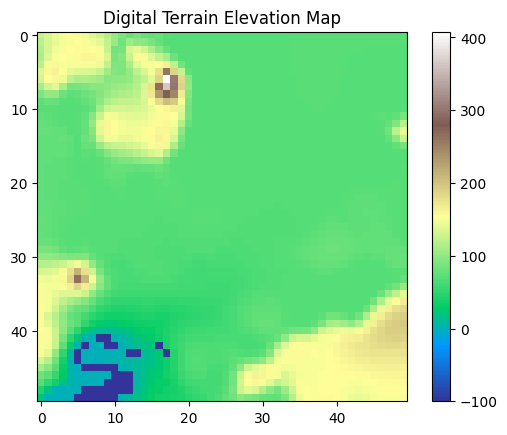

In [ ]:
data = data.to(torch.float32)

#First visualisation
plt.imshow(data, cmap='terrain')
plt.colorbar()
plt.title('Digital Terrain Elevation Map')
plt.show()


The image shows the original data with -100 values indicating missing data. These are shown in a different color (blue), distinct from the actual elevation values, indicating the areas with no elevation data.


In [ ]:
data = data.to(torch.float32)
data[data == -100] = float('nan')

num_missing_values = torch.isnan(data).sum().item()
print(f"Number of missing values: {num_missing_values}")
data_np = data.numpy()

Number of missing values: 36


the missing values 36 are relatively few compared to the size of your dataset (50x50)

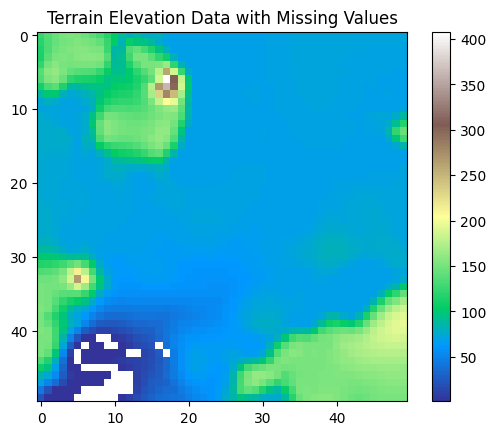

In [ ]:
# Assuming data_np is a 2D numpy array
plt.imshow(data_np, cmap='terrain')
plt.colorbar()
plt.title('Terrain Elevation Data with Missing Values')
plt.show()

The image illustrates the data after replacing -100 values with NaN. The NaN values appear as holes (in white) but at the bottom of the screen against the terrain colormap of the rest of the elevation data. This is because NaN values are not plotted and appear as gaps in the visualization.

With some research I found out two ways through which we can proceed:

1.   Letting the missing values as it is and continuing with the compilation of the model
2.   Interpolation







In [ ]:
from scipy.interpolate import griddata

# Creating coordinates for the grid
x = np.arange(data_np.shape[1])
y = np.arange(data_np.shape[0])
xx, yy = np.meshgrid(x, y)

# Mask for valid (non-NaN) data points
valid_mask = ~np.isnan(data_np)

# Coordinates and values of the known data points
known_x = xx[valid_mask]
known_y = yy[valid_mask]
known_data = data_np[valid_mask]

# Interpolate using griddata
interpolated_data = griddata(
    points=(known_x, known_y),
    values=known_data,
    xi=(xx, yy),                # Coordinates where interpolation is performed
    method='cubic'
)

#Replace NaN with interpolated values
data_np[~valid_mask] = interpolated_data[~valid_mask]

# Checking if there are any NaNs left
assert not np.isnan(data_np).any(), "Some NaNs remain after interpolation."

I chose the second option as filling out 36 values by simple interpolation technoique would make the model train better rather than discarding that portion of the image

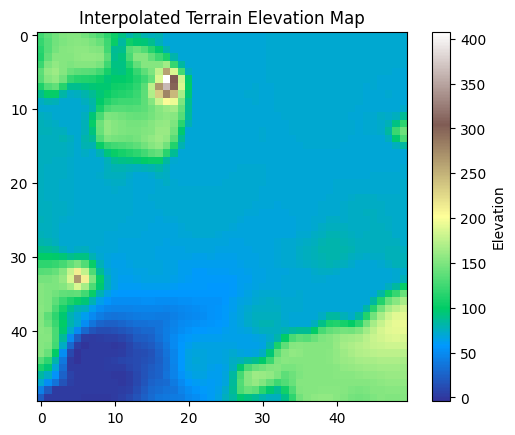

In [ ]:
# Visualize the interpolated data
plt.imshow(data_np, cmap='terrain')
plt.colorbar(label='Elevation')
plt.title('Interpolated Terrain Elevation Map')
plt.show()

As we can see now the image looks fine and has no missing values in the image

# Model Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split

#Coverting 2D array into 1D array
coords = np.array([[i, j] for i in range(data_np.shape[0]) for j in range(data_np.shape[1])])
elevations = data_np.flatten()


coords_tensor = torch.tensor(coords, dtype=torch.float32)
elevations_tensor = torch.tensor(elevations, dtype=torch.float32)


# Here, we'll use 80% of the data for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(coords_tensor, elevations_tensor, test_size=0.2, random_state=42)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: torch.Size([2000, 2])
y_train shape: torch.Size([2000])
X_test shape: torch.Size([500, 2])
y_test shape: torch.Size([500])


In [ ]:
from sklearn.preprocessing import StandardScaler
# Convert coords_tensor to numpy for scaling
coords_np = coords_tensor.numpy()

# Create the scaler instance and fit it to the coordinates
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords_np)

# Convert back to tensor
coords_tensor_scaled = torch.tensor(coords_scaled, dtype=torch.float32)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(coords_tensor_scaled, elevations_tensor, test_size=0.2, random_state=42)


Here, I chose standard scalar to scale the data to scale the data down which would help me more in the convergence of data, especially as I am using LinearRegression.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Defining a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(2, 1)  # 2 input features (x, y coordinates), 1 output feature (elevation)

    def forward(self, x):
        return self.linear(x)

# Initializing the model
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)  # Adjust the learning rate if needed

# Training the model
def train_model(model, X_train, y_train, optimizer, criterion, epochs):
    model.train()
    losses=[]
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_predicted = model(X_train)
        loss = criterion(y_predicted, y_train.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')
    return losses


epochs = 1500
losses=train_model(model, X_train, y_train, optimizer, criterion, epochs)

# Evaluating the model
model.eval()
with torch.no_grad():
    y_predicted = model(X_test).squeeze()
    test_loss = criterion(y_predicted, y_test)

print(f'Test Loss: {test_loss.item()}')


Epoch [1/1500], Loss: 8326.0166015625
Epoch [11/1500], Loss: 8152.41162109375
Epoch [21/1500], Loss: 7984.68115234375
Epoch [31/1500], Loss: 7821.6298828125
Epoch [41/1500], Loss: 7663.17626953125
Epoch [51/1500], Loss: 7508.76220703125
Epoch [61/1500], Loss: 7357.87158203125
Epoch [71/1500], Loss: 7210.1025390625
Epoch [81/1500], Loss: 7065.2314453125
Epoch [91/1500], Loss: 6923.15283203125
Epoch [101/1500], Loss: 6783.8212890625
Epoch [111/1500], Loss: 6647.205078125
Epoch [121/1500], Loss: 6513.27294921875
Epoch [131/1500], Loss: 6381.99365234375
Epoch [141/1500], Loss: 6253.3330078125
Epoch [151/1500], Loss: 6127.2568359375
Epoch [161/1500], Loss: 6003.73388671875
Epoch [171/1500], Loss: 5882.732421875
Epoch [181/1500], Loss: 5764.2177734375
Epoch [191/1500], Loss: 5648.1591796875
Epoch [201/1500], Loss: 5534.5224609375
Epoch [211/1500], Loss: 5423.2763671875
Epoch [221/1500], Loss: 5314.38916015625
Epoch [231/1500], Loss: 5207.828125
Epoch [241/1500], Loss: 5103.56201171875
Epoch 

**Geometrical Meaning**

Linear Regression Model: The model aims to discover the optimal linear relationship between multiple input features(x and y coordinates) and a single output feature (elevation). It does this by adjusting the weights (coefficients) to minimize the error between predicted outputs and actual outputs, essentially finding the best-fitting hyperplane in a multidimensional space.

Hyperplane:  The combination of these weights and the bias defines a plane in a 3-dimensional space spanned by the x coordinate, y coordinate, and elevation. This plane represents the model's best attempt at fitting a linear relationship that captures the variation in elevation across different coordinates on the terrain.

**A neural network?**

Yes, the model can be regarded as a very basic form of a neural network, specifically a single-layer perceptron without any activation function. It demonstrates the fundamental concept of learning from input features to predict an output but lacks the complexity and depth of multi-layer neural networks.



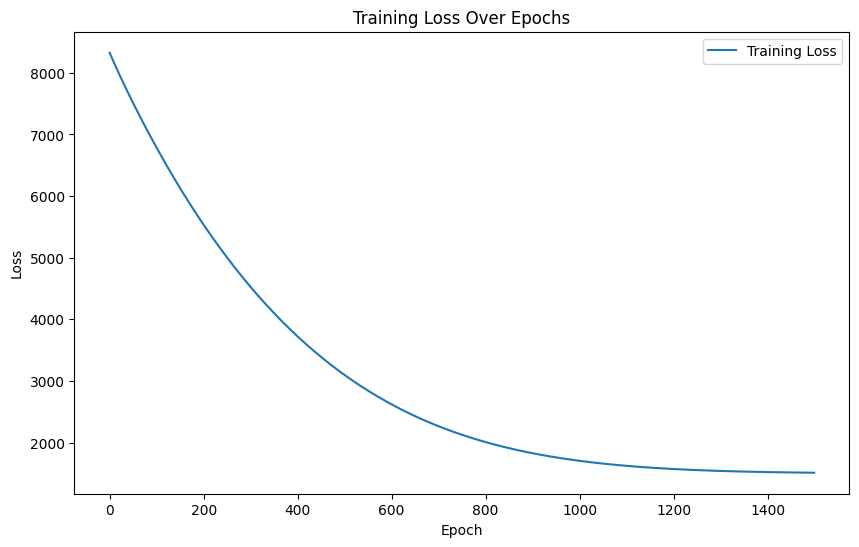

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Here we see the training of the model hitting a plateau.

In my experience this could happen for the following reason :

- The linear model is too simple to capture the complexity or the non-linear relationships present in the data.
- The true relationship between the coordinates and elevation is non-linear or involves interactions between the features that a simple linear model cannot capture, this would limit the decrease in loss, resulting in the plateau.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()


with torch.no_grad():
    predictions = model(X_test).squeeze()


predictions_linear = predictions.numpy()
y_test_np = y_test.numpy()


mae = mean_absolute_error(y_test_np, predictions_linear)
mse = mean_squared_error(y_test_np, predictions_linear)
r2 = r2_score(y_test_np, predictions_linear)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Mean Absolute Error (MAE): 26.60
Mean Squared Error (MSE): 1740.14
R-squared (R2): -0.03




The errors suggests the following:


*   **MAE**: Shows that the predictions are bad, as even the average mean of errors lie 26.72 units aways from the actual elevation

*   **MSE**: Suggests that there are either many moderate errors or some very large errors in prediction, or a combination of both. It indicates that the model's predictions are generally not close to the actual values
*   **R-squared (R2) of -0.01**: The R-squared value indicates the proportion of the variance in the dependent variable (elevation) that is predictable from the independent variables (coordinates). An R-squared value of -0.03 is close to zero, which would indicate no predictive power from the model. However, being negative, it suggests that the model is even worse than a simple mean of the target values for prediction purposes. Essentially, the model does not capture any of the variability of the response data around its mean.


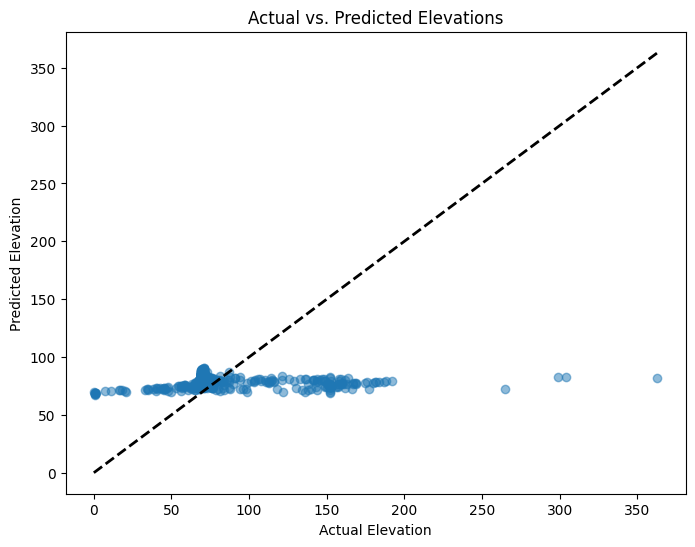

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, predictions_linear, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'k--', lw=2)
plt.xlabel('Actual Elevation')
plt.ylabel('Predicted Elevation')
plt.title('Actual vs. Predicted Elevations')
plt.show()


The above scatter plot compares actual elevations to predicted elevations.

The insights it provided:

1.   The points represent individual predictions, where the x-value is the actual elevation and the y-value is the predicted elevation.

2.   The dashed line indicates the line of perfect prediction. Points along this line would represent perfect accuracy, where the predicted values exactly match the actual values.

3.   The dense cluster of points along the lower part of the graph suggests the model is accurate for lower elevations but the accuracy decreases as elevation increases.

4.   Outliers that appear further from the line indicate instances where the model's predictions were significantly different from the actual values.

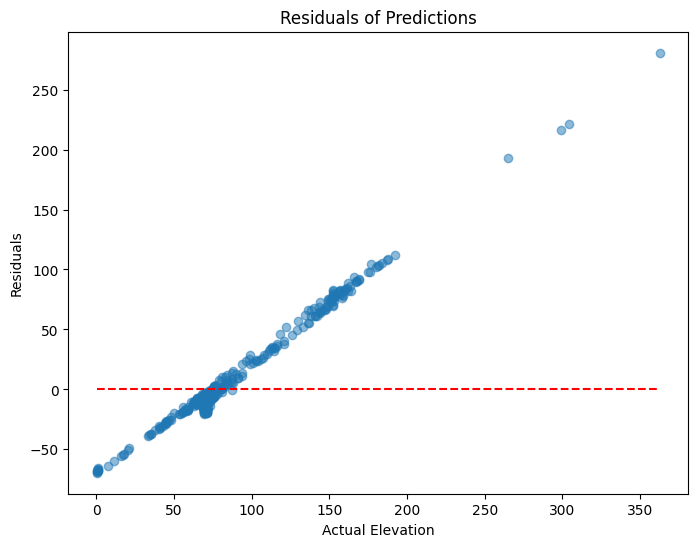

In [ ]:
residuals = y_test_np - predictions_linear

plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_test_np.min(), xmax=y_test_np.max(), colors='red', linestyles='--')
plt.xlabel('Actual Elevation')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()


The horizontal axis shows actual elevations, the vertical axis measures residuals (the differences between actual and predicted elevations), and the red dashed line represents where residuals would be if predictions were perfect.
Most residuals are positive, indicating that the model often predicts

*   Most residuals are positive, indicating that the model often predicts elevations that are lower than the actual elevations, particularly for higher terrain elevations.

*   There is a clear pattern in the residuals, suggesting a systematic error in the model, especially apparent as actual elevations increase, the model consistently underestimates the elevation. This indicates the model's limitation in capturing the true variations at higher elevations.



# Model Enhancement with Basis Functions

In [ ]:
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()


In [ ]:
from sklearn.cluster import KMeans
#Using KMeans to find 10 cluster centers
kmeans = KMeans(n_clusters=10, random_state=42).fit(coords_np)
centers = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Choosing centers for basis functions in a model can be approached in two primary ways:


1. **Random Selection**:

*   **Issue**: Selecting random points might overlook critical aspects of the data or result in duplicate centers that capture similar information, which could limit the model's potential effectiveness.

2. **Strategic Selection**:

*  **Benefit**: It creates a balance between the coverage of the entire dataset and the distinct features within the data


**Why i chose Kmeans** :

*  KMeans excels in detecting densely populated regions within the input space, establishing a representative sample of centers.
*  Unlike random selection, which can neglect significant data features or create redundant overlaps, KMeans methodically optimizes center selection, enhancing the model's data representation capabilities.





In [ ]:
from scipy.spatial.distance import cdist

    # Transforming both training and testing data using the basis functions
def basis_function_transform(data, centers):
    # Calculating the squared distance between each data point and each center
    distances = cdist(data, centers, 'euclidean')
    # Applying the transformation
    return np.exp(-distances)

X_train_transformed = basis_function_transform(X_train.numpy(), centers)
X_test_transformed = basis_function_transform(X_test.numpy(), centers)


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_transformed, y_train_np)


predictions_basis = model.predict(X_test_transformed)
mse = mean_squared_error(y_test_np, predictions_basis)

print(f"Mean Squared Error on transformed test data: {mse}")
mae = mean_absolute_error(y_test_np, predictions_basis)
print(f"Mean Absolute Error on transformed test data: {mae}")
r2 = r2_score(y_test_np, predictions_basis)
print(f"R-squared on test data: {r2}")


Mean Squared Error on transformed test data: 1041.3553680994542
Mean Absolute Error on transformed test data: 19.347611124589267
R-squared on test data: 0.38401476318473315


# Model Comparison and Analysis

The provided metrics indicate the performance of a model that has been enhanced with basis functions, compared to the initial simple linear model.

The insights drawn from the comparison:

*   **MSE**: Lower than the MSE of simple linear model. This suggests that the basis functions model has a better fit as it has reduced the average squared differences between the predicted and actual elevation values.

*   **MAE**: Lower MAE indicates that the average magnitude of errors in the predictions has decreased.
*   **MSE**: Lower than the MSE of simple linear model. This suggests that the basis functions model has a better fit as it has reduced the average squared differences between the predicted and actual elevation values.


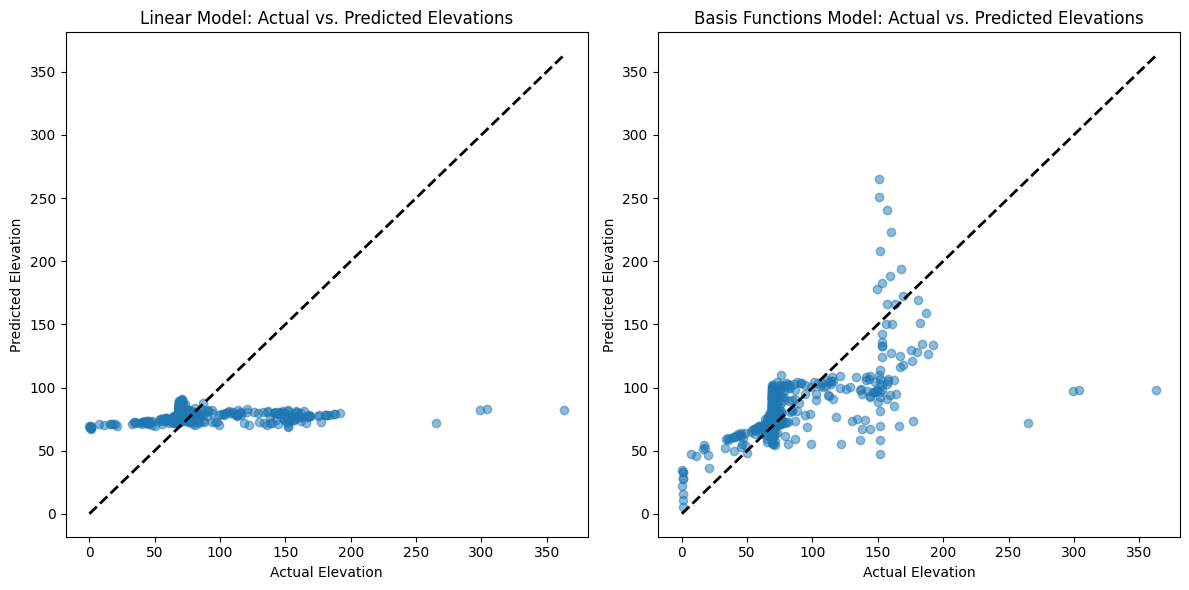

In [ ]:

actual_elevations = y_test_np

# Plotting actual vs. predicted for the linear model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(actual_elevations, predictions_linear, alpha=0.5)
plt.plot([actual_elevations.min(), actual_elevations.max()], [actual_elevations.min(), actual_elevations.max()], 'k--', lw=2)
plt.xlabel('Actual Elevation')
plt.ylabel('Predicted Elevation')
plt.title('Linear Model: Actual vs. Predicted Elevations')

# Plotting actual vs. predicted for the model with basis functions
plt.subplot(1, 2, 2)
plt.scatter(actual_elevations, predictions_basis, alpha=0.5)
plt.plot([actual_elevations.min(), actual_elevations.max()], [actual_elevations.min(), actual_elevations.max()], 'k--', lw=2)
plt.xlabel('Actual Elevation')
plt.ylabel('Predicted Elevation')
plt.title('Basis Functions Model: Actual vs. Predicted Elevations')

plt.tight_layout()
plt.show()


The graph represents actual versus predicted elevations for both the linear model and the basis functions model. In an ideal scenario, if the predictions were perfect, all points would lie on the dashed line indicating a perfect match between actual and predicted elevations.

1.   **Simple Linear Model Insights**:
The graph shows a tight grouping of predicted elevations around the lower actual elevations. This suggests that the model is reasonably effective at predicting the terrain where the elevation changes are minimal or more consistent.
However, as the actual elevation increases, the model’s predictions start to diverge significantly from the line of perfect prediction . This indicates the model's failure to accurately represent the more complex, three-dimensional variations of the terrain, particularly at higher elevations where we would expect more variation in the landscape.

2.   **Basis Functions Model Insights**:
The graph exhibits a broader dispersion of predicted elevations that align more closely with the actual elevations across a wider range. This indicates an improved ability to capture medium elevation variations in addition to the lower elevations.
Unlike the simple linear model, the basis functions model seems to better grasp the 3D characteristics of the terrain. It displays a more better understanding of elevation changes, reflecting the model’s enhanced capacity to account for the non-linear and multidimensional nature of the terrain.



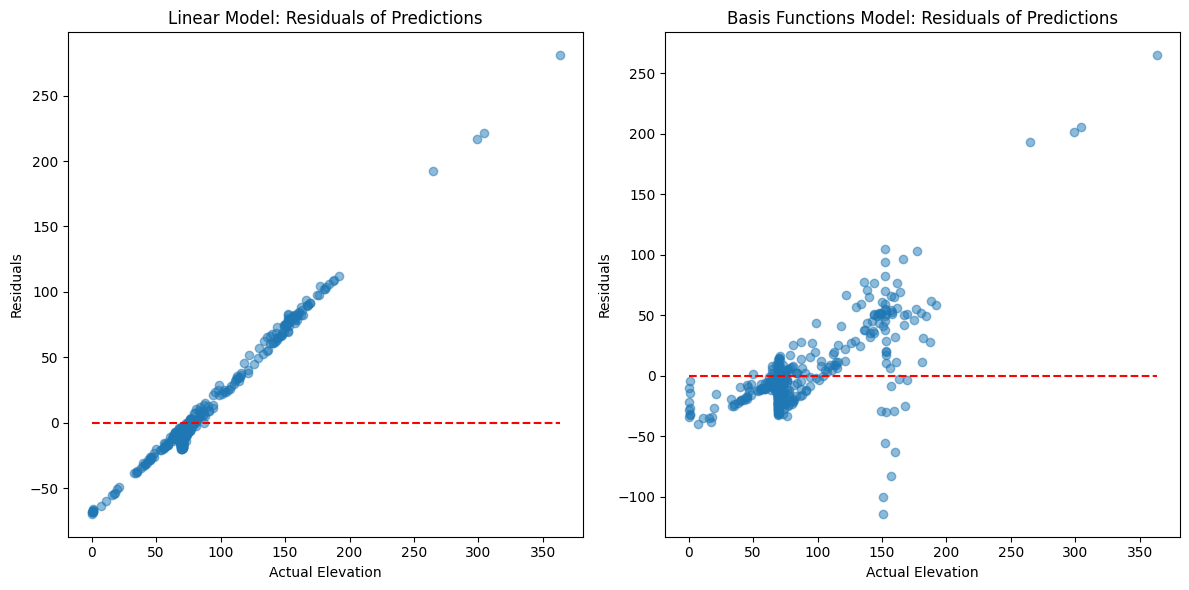

In [ ]:
# Calculating residuals
residuals_linear = actual_elevations - predictions_linear
residuals_basis = actual_elevations - predictions_basis

# Plotting residuals for the linear model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(actual_elevations, residuals_linear, alpha=0.5)
plt.hlines(y=0, xmin=actual_elevations.min(), xmax=actual_elevations.max(), colors='red', linestyles='--')
plt.xlabel('Actual Elevation')
plt.ylabel('Residuals')
plt.title('Linear Model: Residuals of Predictions')

# Plotting residuals for the model with basis functions
plt.subplot(1, 2, 2)
plt.scatter(actual_elevations, residuals_basis, alpha=0.5)
plt.hlines(y=0, xmin=actual_elevations.min(), xmax=actual_elevations.max(), colors='red', linestyles='--')
plt.xlabel('Actual Elevation')
plt.ylabel('Residuals')
plt.title('Basis Functions Model: Residuals of Predictions')

plt.tight_layout()
plt.show()


The plot compares the differences between the actual and predicted elevations, for both the linear and basis functions models. Ideally, if a model made perfect predictions, all residuals would be zero, and the points would align along the horizontal line.


**Simple Linear Model Residuals Insights**:

1.   There's a clear pattern in the residuals: as the actual elevation increases, the residuals also increase.This trend suggests a systematic error in the model's predictions, indicating that it consistently underestimates the elevation at higher levels.

2.   The residuals are not scattered randomly around the horizontal line, which means that the model does not account for some of the variability in the terrain's elevation, particularly at higher elevations.

3.   The presence of several points far from the horizontal line shows instances of significant underestimation, which is due to the model's inability to capture the complex features of the terrain.



**Basis Functions Model Residuals Insights**:


1.   The residuals for the basis functions model are more randomly scattered around the horizontal line, indicating a better fit as there is less systematic error compared to the linear model.

2.   Despite the improved randomness, there's still a cluster of residuals below the line for mid-range actual elevations, suggesting a tendency of the model to overestimate in this range.

3.   The wider spread of residuals implies that the basis functions model captures the variation in elevation more effectively, accommodating the terrain's non-linear aspects, though it is not without its inaccuracies as evidenced by some outliers.




# Additional Insights and Responses






1.  Using a small number of basis functions, like 10, provided a rough approximation of the terrain's elevation. The model may not capture the complexity of the data. It's like trying to understand a mountain range using only a handful of measurements - you might get the general shape, but you'll miss the valleys and peaks.

2. When the number of basis functions was increased, the model's ability to read the terrain improved, reducing prediction errors. However, as the basis functions increased, the risk of the model fitting to the noise, the minor fluctuations and anomalies in the elevation data that aren't part of the underlying terrain structure also increased.  While this model may perform exceptionally well on the training data, capturing every nook and cranny, its ability to generalize to unseen data could be compromised.



















*   This would lead to a model as complex as the data itself. While it could capture every small thing in the training set perfectly, it's like creating a map with every rock and blade of grass. It might be too detailed to be useful for understanding the terrain's general layout. If a new piece of terrain data is slightly different, the model might give an inaccurate prediction because it's too fixated on the details of the training set.



Following are the ideas I could think of to model this data better:

*   Polynomial Regression : Extending the linear model by adding polynomial terms of the feature can capture non linear realationships by allowing the model to fit a curved line.

*   Using KNN Regression : For a new prediction point , KNN will calculate the distance between this point and all the points in the training data. Averaging the elevation values of the k nearest neighbors will estimate the value better than a simiple linear model in my assumption.

*   Using a Multilayer Neural Network : As we already used a single layer perceptron, extending it to a multilayer perceptron and actually making the model learn the patterns should give better results.



Handling a dataset as large as a 1,000,000 x 1,000,000 grid would be very different than how we tackeled this problem.

**Challenges**

*   Better Computational Resources and an Efficient Data Storage:
Traditional computing environments like the combination of a macbook and google colab which I am using that is lack of good gpu's may struggle processing such large grid of data. We will need a big disk space and an efficient data management system to access and retrieve the necessary data quickly.

*   Model Training Time will increase substantially

*   Analyzing and visualizing results would not be as easy, hence requireing more use of tools than just matplotlib.

**Solutions/Strategies**

*   Data Sampling or Partitioning: Instead of using the entire dataset, we could sample a representative subset of the data for initial modeling efforts. Alternatively, partitioning the data into smaller chunks and processing them individually can make the problem more manageable.


*   Dimensionality Reduction: Techniques like Principal Component Analysis (PCA) can reduce the number of features in the dataset, simplifying the models without losing significant information.


*    Convolutional Neural Networks :  Using CNN to capture the spatial data and its ability to capture the complexity of the features I believe would be very useful. Experimenting with different architetures, hyperparameters and also augmenting data can give us really good results.